In [1]:
import numpy as np
from datetime import date

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import effectivecurrent2brightness as ec2b
from pulse2percept.utils import TimeSeries

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def setup_model(exp_params):
    model = dict()
    
    # set up temporal model
    model['tm'] = ec2b.TemporalModel(model=exp_params['model'],
                                     tsample=exp_params['tsample'])
    
    # Create a Retina object that can hold the entire Argus I array
    r_sampling = 250  # spatial sampling of retina
    r_file = '../retina_argus_s' + str(r_sampling) + '.npz'
    model['retina'] = e2cm.Retina(axon_map=r_file, sampling=r_sampling,
                                  xlo=-2500, xhi=2500, ylo=-2500, yhi=2500)
    
    # Place electrode array
    # Argus I: 4x4 checkerboard, 880um center-to-center,
    # (almost) alternating electrode sizes
    e_spacing = 880  # um
    x_coord = np.arange(0, 4) * e_spacing - 1.5 * e_spacing
    x_coord, y_coord = np.meshgrid(x_coord, x_coord, sparse=False)

    # spatial arrangement of Argus I creates checkerboard with alternating electrode sizes
    #   .  o  .  o
    #   o  .  o  .
    #   .  o  .  o
    #   o  .  o  .
    r_arr = np.array([260, 520, 260, 520])
    r_arr = np.concatenate((r_arr, r_arr[::-1], r_arr, r_arr[::-1]), axis=0)
    h_arr = np.ones(16)*100

    model['implant'] = e2cm.ElectrodeArray(r_arr.tolist(), x_coord.flatten().tolist(),
                                           y_coord.flatten().tolist(), h_arr.tolist())
    
    # We derive the effective current stimulation (ecs; passed through the effect of
    # the retinal layout, axons, etc.) in addition to the current (cs):
    model['ecs'], model['cs'] = model['retina'].electrode_ecs(model['implant'])
    
    return model

In [3]:
def run_condition(idx_cond, exp_params, model):
    """Run a single condition of the Horsager experiment"""
    
    idx_E1 = exp_params['idx_E1']
    idx_E2 = exp_params['idx_E2']
    
    # Set up currents and delays
    if idx_cond == 1:
        # Condition 1: E1 fixed, all others zero
        amp_E1 = np.linspace(0.8, 1.2, 5) * exp_params['amp_ref']
        amp_E2 = np.zeros_like(amp_E1)
        delays = [0]
    elif idx_cond == 2:
         # Condition 2: E2 fixed, all others zero
        amp_E2 = np.linspace(0.8, 1.2, 5) * exp_params['amp_ref']
        amp_E1 = np.zeros_like(amp_E2)
        delays = [0]
    elif idx_cond == 3:
        # Condition 3: E1 fixed, E2 varies
        # Make current sum to 75% - 125% of amp_ref
        amp_E2 = np.linspace(0.4, 0.85, 9) * exp_params['amp_ref']
        amp_E1 = np.ones_like(amp_E2) * 0.35 * exp_params['amp_ref']
        delays = [0.075/1000, 0.375/1000, 1.8/1000, 9/1000]
    elif idx_cond == 4:
        # Condition 4: E2 fixed, E1 varies
        amp_E1 = np.linspace(0.4, 0.85, 9) * exp_params['amp_ref']
        amp_E2 = np.ones_like(amp_E1) * 0.35 * exp_params['amp_ref']
        delays = [0.075/1000, 0.375/1000, 1.8/1000, 9/1000]
    elif idx_cond == 5:
        # Condition 5: Both E1 and E2 vary
        amp_E1 = np.linspace(0.4, 0.6, 9) * exp_params['amp_ref']
        amp_E2 = np.linspace(0.4, 0.6, 9) * exp_params['amp_ref']
        delays = [0.075/1000, 0.375/1000, 1.8/1000, 9/1000]
    else:
        raise ValueError('Unknown idx_cond ' + str(idx_cond))
        
    data = dict()
    data['frames'] = []
    data['amp_E1'] = []
    data['amp_E2'] = []
    data['delay'] = []
    print ("- Condition %d" % idx_cond)
    for dd in delays:
        print("  - delay %.3f" % (dd*1000))
        
        for a1, a2 in zip(amp_E1, amp_E2):
            # generate list of pulse trains
            pt_list = []
            for j in range(16):
                if j == idx_E1:
                    pt_list.append(get_pulse_train(a1, tsample=exp_params['tsample']))
                elif j == idx_E2:
                    pt_list.append(get_pulse_train(a2, delay_dur=dd,
                                                   tsample=exp_params['tsample']))
                else:
                    pt_list.append(get_pulse_train(0, tsample=exp_params['tsample']))
            
            # calculate response
            resp = ec2b.pulse2percept(model['tm'], model['cs'], model['retina'],
                                      pt_list, 30, dojit=True, n_jobs=4)

            # save data
            data['frames'].append(resp)
            data['amp_E1'].append(a1)
            data['amp_E2'].append(a2)
            data['delay'].append(dd)
            
    return data

In [4]:
def run_experiment(exp_params, model):
    print('Experiment: %s (%s, %s)' % (exp_params['name'],
                                       exp_params['name_E1'],
                                       exp_params['name_E2']))

    exp_params['date'] = date.today().strftime("%Y-%m-%d")
    # Generate filename and make sure we can write to it
    # Do this now rather than after hours of number crunching...
    filename = '%s%s_E%d_E%d_%s_%.1fX.npz' % (exp_params['save_dir'],
                                              exp_params['name'],
                                              exp_params['idx_E1'],
                                              exp_params['idx_E2'],
                                              exp_params['date'],
                                              exp_params['fac_thresh'])
    exp_params['filename'] = filename
    np.savez(filename, data=np.zeros(10))

    # Run all 5 conditions
    data = dict()
    for idx_cond in range(5):
        name_cond = 'cond' + str(idx_cond + 1)
        data[name_cond] = run_condition(idx_cond + 1, exp_params, model)

    # Save results to .npz
    np.savez(filename, data=data, exp_params=exp_params, model=model)
    print('- Results saved to %s' % filename)

In [5]:
# We could use ec2b.Psycho2Pulsetrain, but we'd like to have the stimulus first, 
# followed by the inter-pulse gap. ec2b.Psycho2Pulsetrain has the inter-pulse
# gap first...
def get_pulse_train(ampl, delay_dur=0, tsample=1e-5):
    freq = 50
    pulse_dur = 0.45/1000
    stim_dur = 0.5

    # envelope size (single pulse + gap) given by `freq`
    envelope_size = int(np.round((1/freq) / tsample))

    # delay given by `delay_dur`
    delay_size = int(np.round(delay_dur / tsample))
    delay = np.zeros(delay_size)

    # single pulse given by `pulse_dur`
    pulse = ampl * e2cm.get_pulse(pulse_dur, tsample, pulse_dur, 'cathodicfirst')
    pulse_size = pulse.size

    # then gap is used to fill up what's left
    gap_size = envelope_size - delay_size - pulse_size
    gap = np.zeros(gap_size)

    pulse_train = []
    for j in range(int(np.round(stim_dur * freq))):
        pulse_train = np.concatenate((pulse_train, delay, pulse, gap), axis=0)
    
    return TimeSeries(tsample, pulse_train)

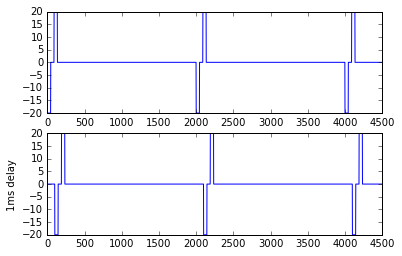

In [6]:
plt.subplot(211)
plt.plot(get_pulse_train(20, 0).data[0:4500])

plt.subplot(212)
plt.plot(get_pulse_train(20, 1/1000).data[0:4500])
plt.ylabel('1ms delay')

In [7]:
exp_params = dict()

# give the experiment a name
exp_params['name'] = 'nanduri'

# where to save the data (relative path)
exp_params['save_dir'] = 'data/'

# sampling step in seconds
exp_params['tsample'] = 5e-6

# some factor x threshold
exp_params['fac_thresh'] = 1.5

# threshold current in micro amps
exp_params['amp_thresh'] = 30

# reference current at `fac_thresh` times threshold
exp_params['amp_ref'] = exp_params['fac_thresh'] * exp_params['amp_thresh']

# model flavor
exp_params['model'] = 'Nanduri'

model = setup_model(exp_params)

In [8]:
idx_E1  = [   2,    6,    9,   12,    4,    9,    0,    0,   14]
name_E1 = ['C1', 'C2', 'B3', 'A4', 'A2', 'B3', 'A1', 'A1', 'C4']
idx_E2  = [   1,    5,    5,   13,    6,    1,    2,   12,    2]
name_E2 = ['B1', 'B2', 'B2', 'B4', 'C2', 'B1', 'C1', 'A4', 'C1']

for idx1, name1, idx2, name2 in zip(idx_E1, name_E1, idx_E2, name_E2):
    exp_params['idx_E1'] = idx1
    exp_params['idx_E2'] = idx2
    exp_params['name_E1'] = name1
    exp_params['name_E2'] = name2
    
    t_exe = %timeit -oq -n1 -r1 run_experiment(exp_params, model)
    print('- Experiment took %.1f s' % t_exe.best)

Experiment: nanduri (C1, B1)
- Condition 1
  - delay 0.000
- Condition 2
  - delay 0.000
- Condition 3
  - delay 0.075
  - delay 0.375
  - delay 1.800
  - delay 9.000
- Condition 4
  - delay 0.075
  - delay 0.375
  - delay 1.800
  - delay 9.000
- Condition 5
  - delay 0.075
  - delay 0.375
  - delay 1.800
  - delay 9.000
- Results saved to data/nanduri_E2_E1_2016-10-07_1.5X.npz
- Experiment took 5501.2 s
Experiment: nanduri (C2, B2)
- Condition 1
  - delay 0.000
- Condition 2
  - delay 0.000
- Condition 3
  - delay 0.075
  - delay 0.375
  - delay 1.800
  - delay 9.000
- Condition 4
  - delay 0.075
  - delay 0.375
  - delay 1.800
  - delay 9.000
- Condition 5
  - delay 0.075
  - delay 0.375
  - delay 1.800
  - delay 9.000
- Results saved to data/nanduri_E6_E5_2016-10-07_1.5X.npz
- Experiment took 5113.2 s
Experiment: nanduri (B3, B2)
- Condition 1
  - delay 0.000
- Condition 2
  - delay 0.000
- Condition 3
  - delay 0.075
  - delay 0.375
  - delay 1.800
  - delay 9.000
- Condition 4
  -